In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pandas as pd

# load pickle:
import pickle
with open('./hawkes_ckpt.pkl', 'rb') as f:
    (target, data) = pickle.load(f)

data

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
0,4.558553,5.497598,7.546720,7.999169,8.909745,9.389590,9.948541,11.397706,12.446528,12.737888,...,976.119951,979.928943,980.166528,984.205776,989.758968,994.04043,994.781698,995.593467,999.242802,999.49605
1,5.123977,5.926751,8.017461,9.585052,11.376419,11.656979,12.766762,14.981932,16.149075,23.902888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.032988,5.534517,8.007285,9.747901,10.559384,12.442873,13.065786,15.540712,15.545484,24.867921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


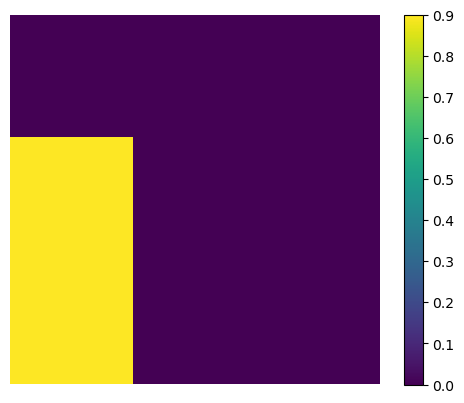

In [2]:
# plot transpose of target matrix:
plt.imshow(target)
plt.axis('off')
plt.colorbar()

In [3]:
X1 = data.loc[0].dropna()
X2 = data.loc[1].dropna()
X3 = data.loc[2].dropna()

print(X1.shape, X2.shape, X3.shape)

(614,) (328,) (396,)


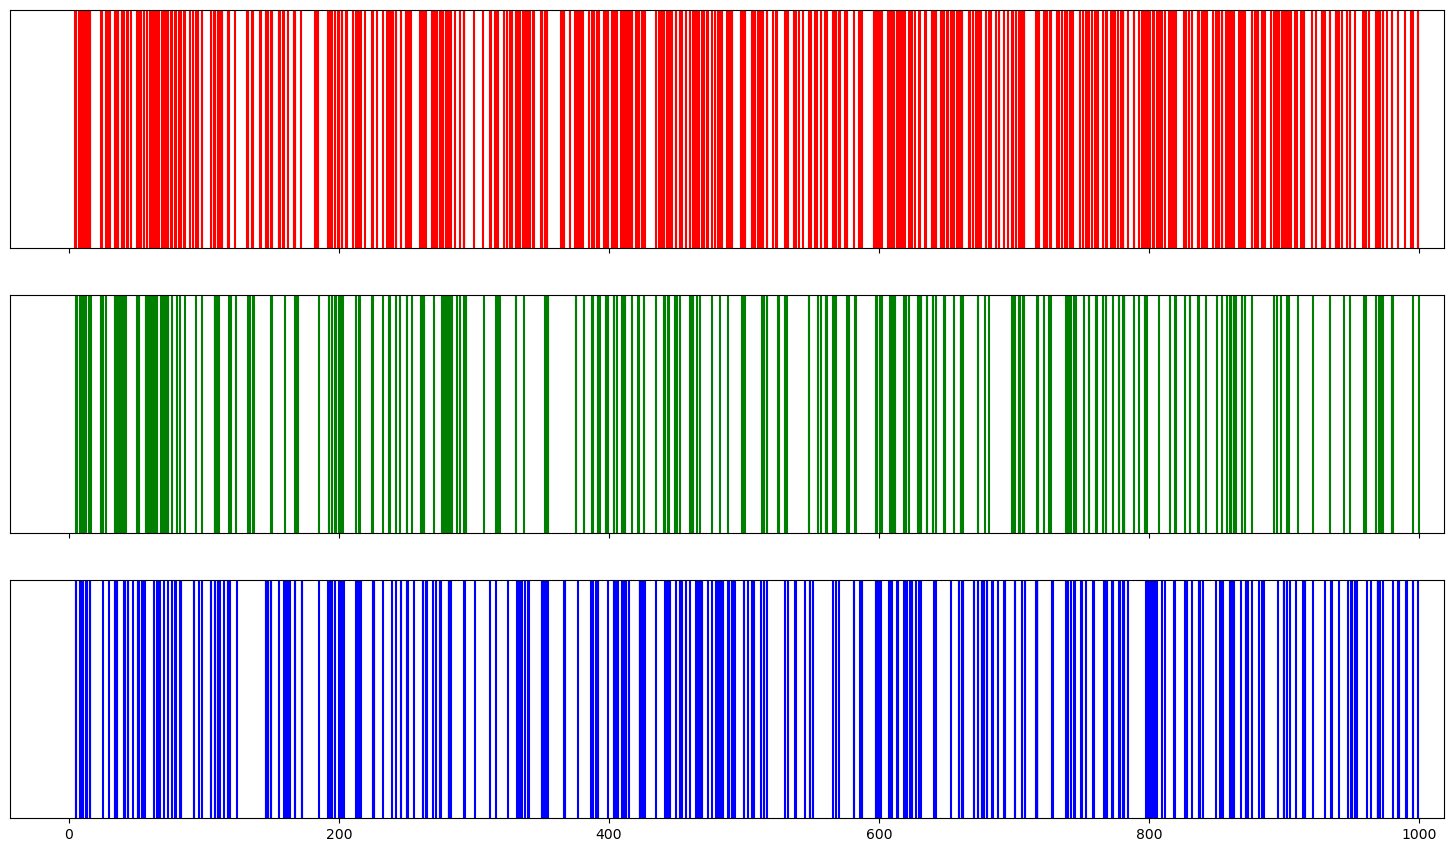

In [4]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"


In [6]:
from torch.distributions import Normal 


class CustomNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.embd = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.Tanh())
        
        self.rnn = nn.GRU(input_size = hidden_dim, hidden_size = int(2*hidden_dim), num_layers = 2, batch_first = True)
        
        self.output = nn.Linear(int(2*hidden_dim), input_dim)

    def forward(self, x):

        x = self.embd(x)
        x, _ = self.rnn(x)
        x = self.output(x)

        return x

class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AffineCouplingLayer, self).__init__()
        
        self.net = CustomNet(input_dim, hidden_dim)
        
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        params = self.net(x1)
        shift, log_scale = params.chunk(2, dim=1)
        z2 = (x2 - shift) * torch.exp(-log_scale)
        z = torch.cat([x1, z2], dim=1)
        log_det_jacobian = -log_scale.sum(dim=1)
        
        return z, log_det_jacobian

    def inverse(self, z):
        z1, z2 = z.chunk(2, dim=1)
        params = self.net(z1)
        shift, log_scale = params.chunk(2, dim=1)
        x2 = z2 * torch.exp(log_scale) + shift
        x = torch.cat([z1, x2], dim=1)
        
        return x

class InvConv1D(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Initialize an orthogonal matrix for 1x1 convolution in 1D
        w_init, _ = torch.linalg.qr(torch.randn(num_features, num_features))
        #w_init = torch.tensor(w_init)

        self.register_buffer('w', w_init)
        self.w_inverse = None

    def forward(self, x):
        # x is of shape (batch_size, num_features)
        # Apply the learned 1x1 convolution (linear transformation)
        z = x @ self.w  # Matrix multiplication for 1D

        # Compute log determinant of the Jacobian for the flow
        log_det_jacobian = torch.slogdet(self.w)[1]
        
        return z, log_det_jacobian

    def inverse(self, z):
        if self.w_inverse is None:
            self.w_inverse = torch.inverse(self.w)
        x = z @ self.w_inverse
        
        return x



class NFBlock(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super().__init__()
        self.invertible_conv = InvConv1D(num_features)
        self.affine_coupling = AffineCouplingLayer(num_features, hidden_dim)

    def forward(self, x):
        z, log_det_jacobian_conv = self.invertible_conv(x)
        
        z, log_det_jacobian_affine = self.affine_coupling(z)
        
        log_det_jacobian = log_det_jacobian_conv + log_det_jacobian_affine
        
        return z, log_det_jacobian

    def inverse(self, z):
        x = self.affine_coupling.inverse(z)
        x = self.invertible_conv.inverse(x)
        
        return x



class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(NormalizingFlow, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.base_dist = Normal(0, 1)
        self.blocks = nn.ModuleList(
            [NFBlock(num_features = input_dim, hidden_dim = hidden_dim) for _ in range(num_layers)]
        )
        
    
    def forward(self, x):
        log_det_jacobian = 0
        
        for layer in self.blocks:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.blocks):
            z = layer.inverse(z)
        return z


    def log_prob(self, x):
        z, ldj = self.forward(x)
        log_pz = self.base_dist.log_prob(z).sum(dim = (1,))
        log_px = log_pz + ldj

        return z, log_px



In [7]:
model = NormalizingFlow(input_dim=4, hidden_dim = 64, num_layers=3)

In [8]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):

        super().__init__()

        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)

       ###


        self.GrangerMatrix = nn.Parameter((torch.empty(self.n_processes, self.n_processes)))
        nn.init.normal_(self.GrangerMatrix, mean=0.5, std=0.1) # very important


        self.models = nn.ModuleList([NormalizingFlow(self.memory_dim, hidden_dim = 16, num_layers = 2) for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.time_of_start = self.get_time_of_start()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()), lr=1e-4, weight_decay = 1e-5) for i in range(self.n_processes)]
        self.g_optimizer = torch.optim.Adam([self.GrangerMatrix], lr = 1e-3, weight_decay=1e-5)
        self.log_GrangerMatrix = []


    def em_step(self, n_steps):
        dic = {}
        self.causes = [[], [], []]
        for i in range(self.n_processes):
            dic[i] = []


        taus = torch.linspace(1, 0.3, steps = n_steps)#
        
        for self.step in range(n_steps):
          for i_proc in range(self.n_processes):
              self.causes[i_proc] = []
              curr = self.processes[i_proc]
              len_curr = len(curr)
              idx_start = 0
              while idx_start < len_curr:
                self.num_events = 50
                events = self.get_events(self.num_events, idx_start, i_proc, 1.0) ## the get_events does the e_step!
                if events:
                  DL = DataLoader(events, batch_size = len(events))

                  for X, cause_rank in DL:

                    loss = self.m_step(i_proc, X, cause_rank)
                    dic[i_proc].append(loss)

                idx_start += self.num_events

              if loss and ((self.step + 1) % 5 == 0 or self.step == 0):
                  print(f'Step: {self.step + 1}, Model: {i_proc}, Loss: {loss}')


        return dic

    def m_step(self, i_proc, X, cause_rank):

        model = self.models[i_proc]
        self.optimizers[i_proc].zero_grad()
        self.g_optimizer.zero_grad()
        z, logp = model.log_prob(X)
        loss = -1*logp

        loss_rnn = (loss * cause_rank).sum()  + -1*(torch.log(cause_rank + 1e-7)).sum()


        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):


            loss_rnn.backward(retain_graph = True)

            self.optimizers[i_proc].step()
            self.g_optimizer.step()
            self.log_GrangerMatrix.append(self.GrangerMatrix.clone().detach())


        else:
            print(f'NaN found in epoch: {self.step}')

        return loss_rnn.item()

    def make_sweep_dict(self):

        dic = {}
        for i in range(self.n_processes):
            target = self.processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)

        return dic


    def sweep(self, pa, pc):
        events = []
        pa_indices = []


        for i, ia in enumerate(pa):
            events.append((ia, 'a'))
            pa_indices.append(i)

        for ic in pc:
            events.append((ic, 'c'))

        lim = self.memory_dim

        events.sort()
        mem = []
        ret = []
        index_start = False

        pa_idx_counter = 0  # Counter to track which index in pa we are at

        for t, e in events:
            if e == 'c':
                if len(mem) >= lim:
                    mem.pop(0)
                mem.append(t)

            if e == 'a':
                # Memory is not full yet
                if len(mem) < lim:
                    pa_idx_counter += 1  # Move to the next pa index
                    continue
                # Retrieve deltas from this time to the cause times
                pp = [t - tc for tc in mem]
                ret.append(pp)
                if not index_start:
                  index_start = pa_indices[pa_idx_counter] # Save index relative to pa
                pa_idx_counter += 1  # Move to the next pa index
        if not index_start:
          index_start = -1
        return torch.tensor(ret, dtype=torch.float), index_start

    def get_time_of_start(self):

      indexs = []
      dic = self.sweep_dict

      for i in dic:
        curr = []
        for j in dic[i]:
          curr.append(dic[i][j][1])
        indexs.append(curr)

      return indexs


    def new_e_step(self, num_events, i_proc, tau):

      in_ = self.GrangerMatrix[i_proc]#.softmax(dim = 0)
      rv = []
      for i in range(num_events):
        cause = F.gumbel_softmax(
            in_,
            tau = tau,
            hard = False
        )
        rv.append(cause)

      self.causes[i_proc].append(rv)

      return rv


    def get_events(self, num_events, idx_start, i_proc, tau, k = 2):

      begin_of_influences = self.time_of_start[i_proc]
      n_causes = self.new_e_step(num_events, i_proc, tau)

      row = self.GrangerMatrix[i_proc].detach().clone()
      
      #sorted_row, _ = torch.sort(row, descending = True)
      #sorted_row = list(sorted_row)
      #threshold = sorted_row[k-1]

      # find k-th largest element in row using quick select:
      def quick_select(arr, k):
        if k > 0 and k <= len(arr):
            pos = partition(arr, 0, len(arr) - 1)
            if pos+1 == k:
                return arr[pos]
            if pos+1 < k:
                return quick_select(arr[pos+1:], k-pos-1)
            return quick_select(arr[:pos], k)
        return None
      
      def partition(arr, low, high):
        pivot = arr[high]
        i = low
        for j in range(low, high):
            if arr[j] > pivot:
                arr[i], arr[j] = arr[j], arr[i]
                i += 1
        arr[i], arr[high] = arr[high], arr[i]
        return i
      
      threshold = quick_select(row, k)

      event_cause = []

      for time in range(num_events):
        causes = n_causes[time]

        for idx_cause, cause in enumerate(causes):

          if idx_cause != i_proc and row[idx_cause] < threshold:
             continue

          inf_begin = begin_of_influences[idx_cause]

          if inf_begin == -1: ## this process cannot be caused by this other process (it started after the current process ended)
            continue

          else:
            if time + idx_start >= inf_begin and len(self.sweep_dict[i_proc][idx_cause][0]) > time + idx_start: ## checking if the current_timestamp could be cause by the process and if there's events pass this time
              app = (self.sweep_dict[i_proc][idx_cause][0][time + idx_start], cause)
              event_cause.append(app)

      return event_cause



In [9]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [10]:
mpp = GrangerMPP(processes, memory_dim = 4)
l = mpp.em_step(n_steps = 150)

Step: 1, Model: 0, Loss: 1483.7640380859375
Step: 1, Model: 1, Loss: 3788.1171875
Step: 1, Model: 2, Loss: 7008.7568359375
Step: 5, Model: 0, Loss: 1006.834716796875
Step: 5, Model: 1, Loss: 4918.40234375
Step: 5, Model: 2, Loss: 5486.45947265625
Step: 10, Model: 0, Loss: 1274.657470703125
Step: 10, Model: 1, Loss: 2701.220947265625
Step: 10, Model: 2, Loss: 4306.2822265625
Step: 15, Model: 0, Loss: 572.1785278320312
Step: 15, Model: 1, Loss: 3021.231201171875
Step: 15, Model: 2, Loss: 3475.08154296875
Step: 20, Model: 0, Loss: 517.2067260742188
Step: 20, Model: 1, Loss: 2041.5609130859375
Step: 20, Model: 2, Loss: 2148.226318359375
Step: 25, Model: 0, Loss: 533.052978515625
Step: 25, Model: 1, Loss: 1813.99951171875
Step: 25, Model: 2, Loss: 2721.327392578125
Step: 30, Model: 0, Loss: 422.0022888183594
Step: 30, Model: 1, Loss: 2469.1064453125
Step: 30, Model: 2, Loss: 2038.3245849609375
Step: 35, Model: 0, Loss: 471.1156005859375
Step: 35, Model: 1, Loss: 1854.8284912109375
Step: 35,

Len of losses: [1950, 1050, 1200]


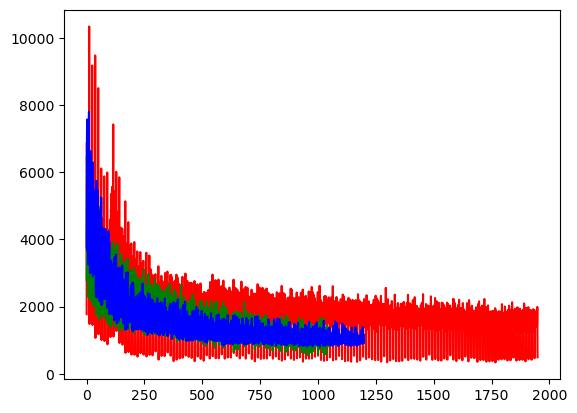

In [11]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

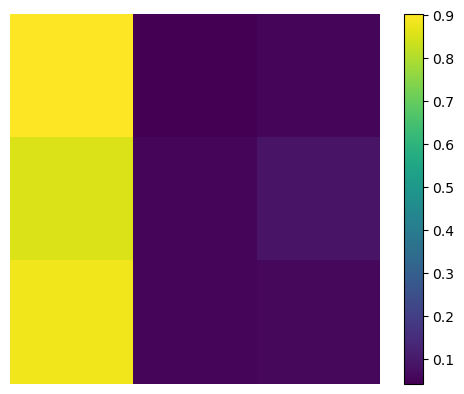

In [12]:
matrix = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(matrix)
plt.axis('off')
plt.colorbar()

In [13]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[ 2.5723586 , -0.47834924, -0.21424103],
       [ 1.8458755 , -0.9298435 , -0.4176846 ],
       [ 1.9988145 , -0.74389994, -0.6701456 ]], dtype=float32)

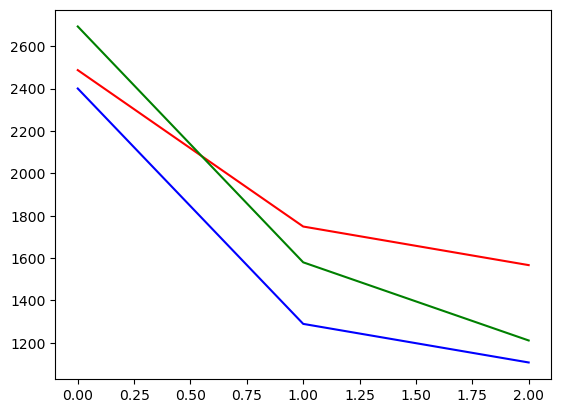

In [14]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [15]:
temp

[2400.6723965731535, 1289.1911217275292, 1106.9648812033913]

In [16]:
s = [i.argmax().item() for i in mpp.causes[0]]
s = torch.tensor(s)
s.unique(return_counts = True)

AttributeError: 'list' object has no attribute 'argmax'

In [79]:
causes = []
for i in mpp.causes[0]:
    for j in i:
        causes.append(j.argmax().item())
causes = torch.tensor(causes)
causes.unique(return_counts = True)

(tensor([0, 1, 2]), tensor([112, 125, 112]))